In [64]:
mode = "png"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [65]:
import numpy as np
from graspologic.simulations import sample_edges

nodenames = [
    "SI", "L", "H/E", 
    "T/M", "BS"
]

# generate probability matrices
n = 5  # the number of nodes
P_earthling = 0.3*np.ones((n, n))
signal_subnetwork = np.zeros((n, n), dtype=bool)
signal_subnetwork[1:n, 0] = True
signal_subnetwork[0, 1:n] = True
P_astronaut = np.copy(P_earthling)
P_astronaut[signal_subnetwork] = np.tile(np.linspace(0.4, 0.9, num=4), 2)

# sample the classes of each sample
M = 200  # the number of training and testing samples
pi_astronaut = 0.45
pi_earthling = 0.55
np.random.seed(0)
ytrain = np.random.choice(2, p=[pi_earthling, pi_astronaut], size=M)
ytest = np.random.choice(2, p=[pi_earthling, pi_astronaut], size=M)

# sample network realizations given the class of each sample
Ps = [P_earthling, P_astronaut]
np.random.seed(0)
Atrain = np.stack([sample_edges(Ps[y]) for y in ytrain], axis=2)
Atest = np.stack([sample_edges(Ps[y]) for y in ytest], axis=2)

In [66]:
from graspologic.subgraph import SignalSubgraph
K = 8  # the number of signal edges
V = 1  # the number of signal nodes

# the incoherent signal subnetwork estimator
ssn_est_inco = SignalSubgraph()
ssn_est_inco.fit_transform(Atrain, labels=ytrain, constraints=K)

# the coherent signal subnetwork estimator
ssn_est_coherent = SignalSubgraph()
ssn_est_coherent.fit_transform(Atrain, labels=ytrain, constraints=[K, V])

(array([0, 4, 0, 2, 0, 3, 0, 1]), array([4, 0, 2, 0, 3, 0, 1, 0]))

In [67]:
ssn_coherent = np.zeros((n, n))
ssn_incoherent = np.zeros((n, n))

ssn_incoherent[ssn_est_inco.sigsub_] = 1
ssn_coherent[ssn_est_coherent.sigsub_] = 1

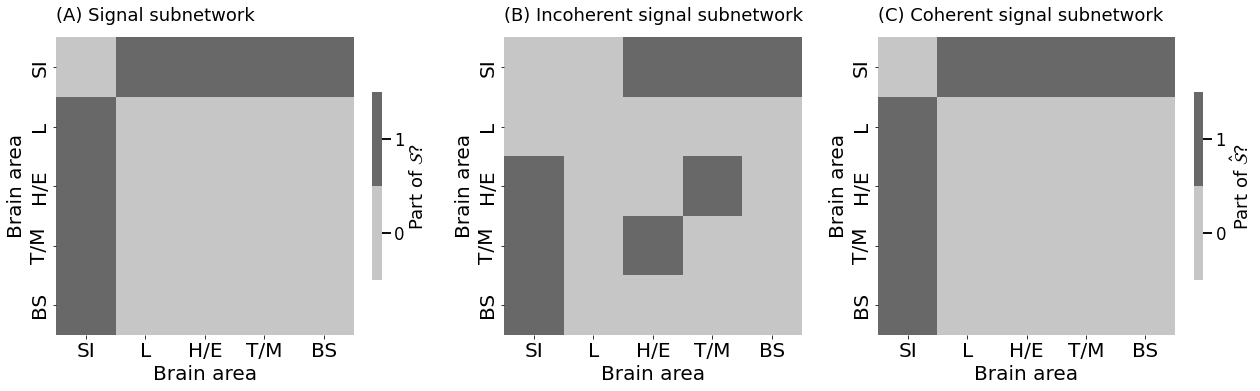

In [74]:
from graphbook_code import heatmap

fig, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={"width_ratios": [1.25, 1, 1.25]})

heatmap(signal_subnetwork.astype(int), ax = axs[0], title="(A) Signal subnetwork",
        xtitle="Brain area", ytitle="Brain area", xticklabels=nodenames, yticklabels=nodenames,
        legend_title="Part of $\\mathcal{S}$?", shrink=0.5)
heatmap(ssn_incoherent.astype(int), ax = axs[1], title="(B) Incoherent signal subnetwork",
        xtitle="Brain area", ytitle="Brain area", xticklabels=nodenames, yticklabels=nodenames,
        legend_title="Edge importance", cbar=False)
heatmap(ssn_coherent.astype(int), ax = axs[2], title="(C) Coherent signal subnetwork",
        xtitle="Brain area", ytitle="Brain area", shrink=0.5, xticklabels=nodenames, yticklabels=nodenames,
        legend_title="Part of $\\hat{\\mathcal{S}}$?")
fig.tight_layout()

fname = "ssn_co"
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))

In [86]:
from sklearn.naive_bayes import BernoulliNB

def train_and_eval_coherent_ssn(Atrain, ytrain, Atest, ytest, K, V):
    """
    A function which trains and tests an incoherent signal subnetwork
    classifier with K signal edges and V signal nodes.
    """
    ssn_mod = SignalSubgraph()
    ssn_mod.fit_transform(Atrain, labels=ytrain, constraints=[int(K), int(V)]);

    Dtrain = Atrain[ssn_mod.sigsub_[0], ssn_mod.sigsub_[1],:].T
    classifier = BernoulliNB()
    # fit the classifier using the vector of classes for each sample
    classifier.fit(Dtrain, ytrain)

    # compute testing data on the estimated signal subnetwork
    Dtest = Atest[ssn_mod.sigsub_[0], ssn_mod.sigsub_[1],:].T
    yhat_test = classifier.predict(Dtest)
    
    # classifier accuracy is the fraction of predictions that are correct
    return (np.mean(yhat_test == ytest), ssn_mod, classifier)

In [87]:
from sklearn.model_selection import KFold
import pandas as pd

kf = KFold(n_splits=20, random_state=None)
xv_res = []
for l, (train_index, test_index) in enumerate(kf.split(range(0, M))):
    A_train, A_test = Atrain[:,:,train_index], Atrain[:,:,test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    nl = len(test_index)
    
    for k in np.arange(2, n*(n-1), step=2):
        for v in range(1, n+1):
            try:
                acc_kl, _, _ = train_and_eval_coherent_ssn(A_train, y_train, A_test, y_test, k, v)
                xv_res.append({"Fold": l, "k": k, "nl": nl, "v": v, "Accuracy": acc_kl})
            except:
                xv_res.append({"Fold": l, "k": k, "nl": nl, "v": v, "Accuracy": np.nan})
xv_data = pd.DataFrame(xv_res)

def weighted_avg(group):
    acc = group['Accuracy']
    nl = group['nl']
    return (acc * nl).sum() / nl.sum()

xv_acc = xv_data.groupby(["k", "v"]).apply(weighted_avg).reset_index(name='Accuracy')
# convert the pandas dataframe (long format) to a data matrix (wide format)
df_hm = xv_acc.pivot("k", "v", "Accuracy")

In [107]:
# the coherent signal subnetwork estimator, using the parameters from xv
ssn_est_coherent_xv = SignalSubgraph()
ssn_est_coherent_xv.fit_transform(Atrain, labels=ytrain, constraints=[6, 1])

ssn_coherent_xv = np.zeros((n, n))
ssn_coherent_xv[ssn_est_coherent_xv.sigsub_] = 1

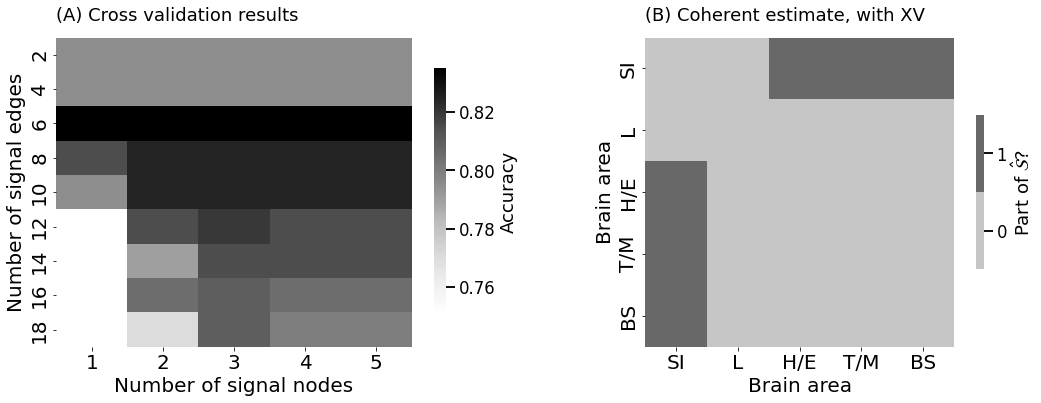

In [112]:
from graphbook_code import lpm_heatmap

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

lpm_heatmap(df_hm, legend_title="Accuracy", ax=axs[0], vmin=.75,
            xtitle="Number of signal nodes", ytitle="Number of signal edges",
            xticklabels=list(xv_acc["v"].unique()), yticklabels=list(xv_acc["k"].unique()),
            title="(A) Cross validation results", shrink=0.8)
heatmap(ssn_coherent_xv.astype(int), ax = axs[1], title="(B) Coherent estimate, with XV",
        xtitle="Brain area", ytitle="Brain area", shrink=0.5, xticklabels=nodenames, yticklabels=nodenames,
        legend_title="Part of $\\hat{\\mathcal{S}}$?")

fig.tight_layout()

fname = "ssn_co_acc"
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))